<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>


<br> <a href="./S6_data_access.ipynb">2 - S6 data access >></a><span style="float:right;"><a href="./4_S6_SLAs.ipynb">4 - S6 Sea-level anomalies >></a> 

## First look at "basic" altimetry data for Sentinel-6, Poseidon-4 altimeter ##

The main point of this exercise is to show you how altimetry data 'looks', and especially to highlight that altimetry data are not (for now) imagery or swath data. Thus you won't have a native grid of pixels, but a 'track' of data.

As usual, we begin by importing required libraries

In [1]:
# to interpret paths and folder for any OS
import os
# math library
import numpy as np
# reading of NetCDF data
import xarray as xr
# plotting library
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import dates
# mapping library
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In the box below, we will set up a few parameters to help our figure plotting later on

In [2]:
#we will look at the plot within the notebooks
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,10)
plt.ioff()
matplotlib.rcParams.update({'font.size': 16})

land_resolution = '50m'
land_poly = cfeature.NaturalEarthFeature('physical', 'land', land_resolution,
                                        edgecolor='k',
                                        facecolor=cfeature.COLORS['land'])

To help to find your data, please complete the MYPATH variable below with the output generated by the /Configuration_Testing/Data_Path_Checker.ipynb Jupyter notebook in the Configuration_Testing folder. 

In [3]:
#MYPATH = os.getcwd()
MYPATH = ''

Sentinel-6 SRAL level 2 data are provided in two versions : High resolution (HR), using the synthetic aperture mode, and Low resolution (LR), working like previous Jason mission (also called "Low-Resolution Mode").  

Within the files, you will find data ordered by "groups". You have two groups depending on the spatial/temporal resolution : data_01 or "1 Hz", i.e. one data point per second, or data_20, "20 Hz", i.e. 20 data points per second. 
Below each of those, you have two groups, one for each of the two frequencies used by the radar, "Ku", the most frequently used, and "C" (only in the low resolution files, not in SAR "HR" mode), mostly used to correct from the delay induced by electrons in the ionosphere. However, the C-band altimetric range, wind speed or SWH can be used on their own. 

The nomenclature of the tar files where the files are stores is 
SATELLITE_P4_level_resolution______begindateTtime_enddateTtime_processingdateTtime_3373_cycle_pass_orbit_EUM__OPE_ST_F03.SEN6

The nomenclature of the file name for these products is SATELLITE_P4_level_resolution_reduced/standard__ST__cycle_pass_begindateTtime_enddateTtime_XXX; 



In [4]:
#look at what is in a Sentinel-6 file folder

input_root = os.path.join(MYPATH,'s6_data')
#hr file !! check production date in folder name
#input_path = 'S6A_P4_2__HR______20211015T182929_20211015T192542_20211016T101339_3373_034_126_063_EUM__OPE_ST_F03.SEN6'
#standard file
#input_file = 'S6A_P4_2__HR_STD__ST_034_126_20211015T182929_20211015T192542_F03.nc'

#lr file
input_path = 'S6A_P4_2__LR______20211015T182929_20211015T192542_20211016T101339_3373_034_126_063_EUM__OPE_ST_F03.SEN6'
#standard file
input_file = 'S6A_P4_2__LR_STD__ST_034_126_20211015T182929_20211015T192542_F03.nc'
#reduced file
#input_file = 'S6A_P4_2__LR_RED__ST_034_126_20211015T182929_20211015T192542_F03.nc'

my_file = os.path.join(input_root,input_path,input_file)
# data are structured in groups; you use each group as you would a separate file.
nc01 = xr.open_dataset(my_file, group='data_01')
nc01ku = xr.open_dataset(my_file, group='data_01/ku')
#20 Hz - only in standard file 
nc20ku = xr.open_dataset(my_file, group='data_20/ku')


# in low-res files only ; 20Hz only in standard files
#nc01c = xr.open_dataset(my_file, group='data_01/c')
#nc20c = xr.open_dataset(my_file, group='data_20/c')

#list the variables within the file and group. Try the different files and groups available. 
for variable in nc01.variables.keys():
    print(variable)

altitude
altitude_rate
altitude_rate_mean_sea_surface
angle_of_approach_to_coast
climato_use_flag
dac
delta_ellipsoid_tp_wgs84
depth_or_elevation
distance_to_coast
geoid
internal_tide
inv_bar_cor
iono_cor_alt
iono_cor_alt_filtered
iono_cor_alt_filtered_mle3
iono_cor_alt_mle3
l2_record_counter
latitude
load_tide_sol1
load_tide_sol2
longitude
manoeuvre_flag
mean_dynamic_topography
mean_dynamic_topography_acc
mean_dynamic_topography_qual
mean_sea_surface_sol1
mean_sea_surface_sol1_acc
mean_sea_surface_sol1_qual
mean_sea_surface_sol2
mean_sea_surface_sol2_acc
mean_sea_surface_sol2_qual
meteo_map_availability_flag
model_dry_tropo_cor_measurement_altitude
model_dry_tropo_cor_zero_altitude
model_wet_tropo_cor_measurement_altitude
model_wet_tropo_cor_zero_altitude
ocean_tide_eq
ocean_tide_non_eq
ocean_tide_sol1
ocean_tide_sol1_qual
ocean_tide_sol2
ocean_tide_sol2_qual
off_nadir_pitch_angle_pf
off_nadir_roll_angle_pf
off_nadir_yaw_angle_pf
orbit_type_flag
pass_direction_flag
pole_tide
rad_cloud

Now we will explore the size and statistics of the file. 

In [5]:
# choose a variable at 1 Hz for now
range_ku = nc01ku.variables['range_ocean'][:]
swh_ocean_01_ku = nc01ku.variables['swh_ocean'][:]
wind_speed_alt = nc01.variables['wind_speed_alt'][:]
ssha_01_ku = nc01ku.variables['ssha'][:]

#flags
range_ocean_qual_01_ku = nc01ku.variables['range_ocean_qual'][:]
swh_ocean_qual_01_ku = nc01ku.variables['swh_ocean_qual'][:]
sig0_ocean_qual_01_ku = nc01ku.variables['sig0_ocean_qual'][:]
surface_type_01 = nc01.variables['surface_classification_flag'][:]
rad_surf_type_01 = nc01.variables['rad_surface_type_flag'][:]

# latitude and longitude are resolution-dependent; they are in the data_01 group for 1 Hz data
# for 20 Hz data they are in data_20/ku 
lat = nc01.variables['latitude'][:]
lon = nc01.variables['longitude'][:]
nc01ku.close()
nc01.close()

#show number of points, min max
print(['array length: ', np.shape(range_ku)])
print(['minimum: ', np.min(range_ku)])
print(['maximum: ', np.max(range_ku)])
print(['mean: ', np.mean(range_ku)])
print(['mean in km: ', np.mean(range_ku)/1000])
print(['standard deviation: ', np.std(range_ku)])

#try the same on the 20 Hz(at least for the shape of the array)
range_20_ku = nc20ku.variables['range_ocean'][:]
#show number of points, min max
print(['array length 20Hz: ', np.shape(range_20_ku)])
nc20ku.close()

['array length: ', (3373,)]
['minimum: ', <xarray.Variable ()>
array(1339436.0995)]
['maximum: ', <xarray.Variable ()>
array(1356045.2017)]
['mean: ', <xarray.Variable ()>
array(1345766.44524391)]
['mean in km: ', <xarray.Variable ()>
array(1345.76644524)]
['standard deviation: ', <xarray.Variable ()>
array(4325.76961277)]
['array length 20Hz: ', (66981,)]


All Sentinel-6 level 2 marine products have quality flags associated with the geophysical variables. These give us confidence in our data, or describe why we cannot make retrievals of the parameters we are interested in. The next cell loads some data from these quality flags for range, significant wave height and surface roughness, as well as surface class information.

In [6]:
# QC variables
range_ku[range_ocean_qual_01_ku != 0.0] = np.nan
swh_ocean_01_ku[swh_ocean_qual_01_ku != 0.0] = np.nan
ssha_01_ku[range_ocean_qual_01_ku != 0.0] = np.nan
ssha_01_ku[surface_type_01 != 0.0] = np.nan
ssha_01_ku[rad_surf_type_01 != 0.0] = np.nan
wind_speed_alt[sig0_ocean_qual_01_ku != 0.0] = np.nan

Now lets plot our along track data (against latitude) and show where our flags suggest bad data.

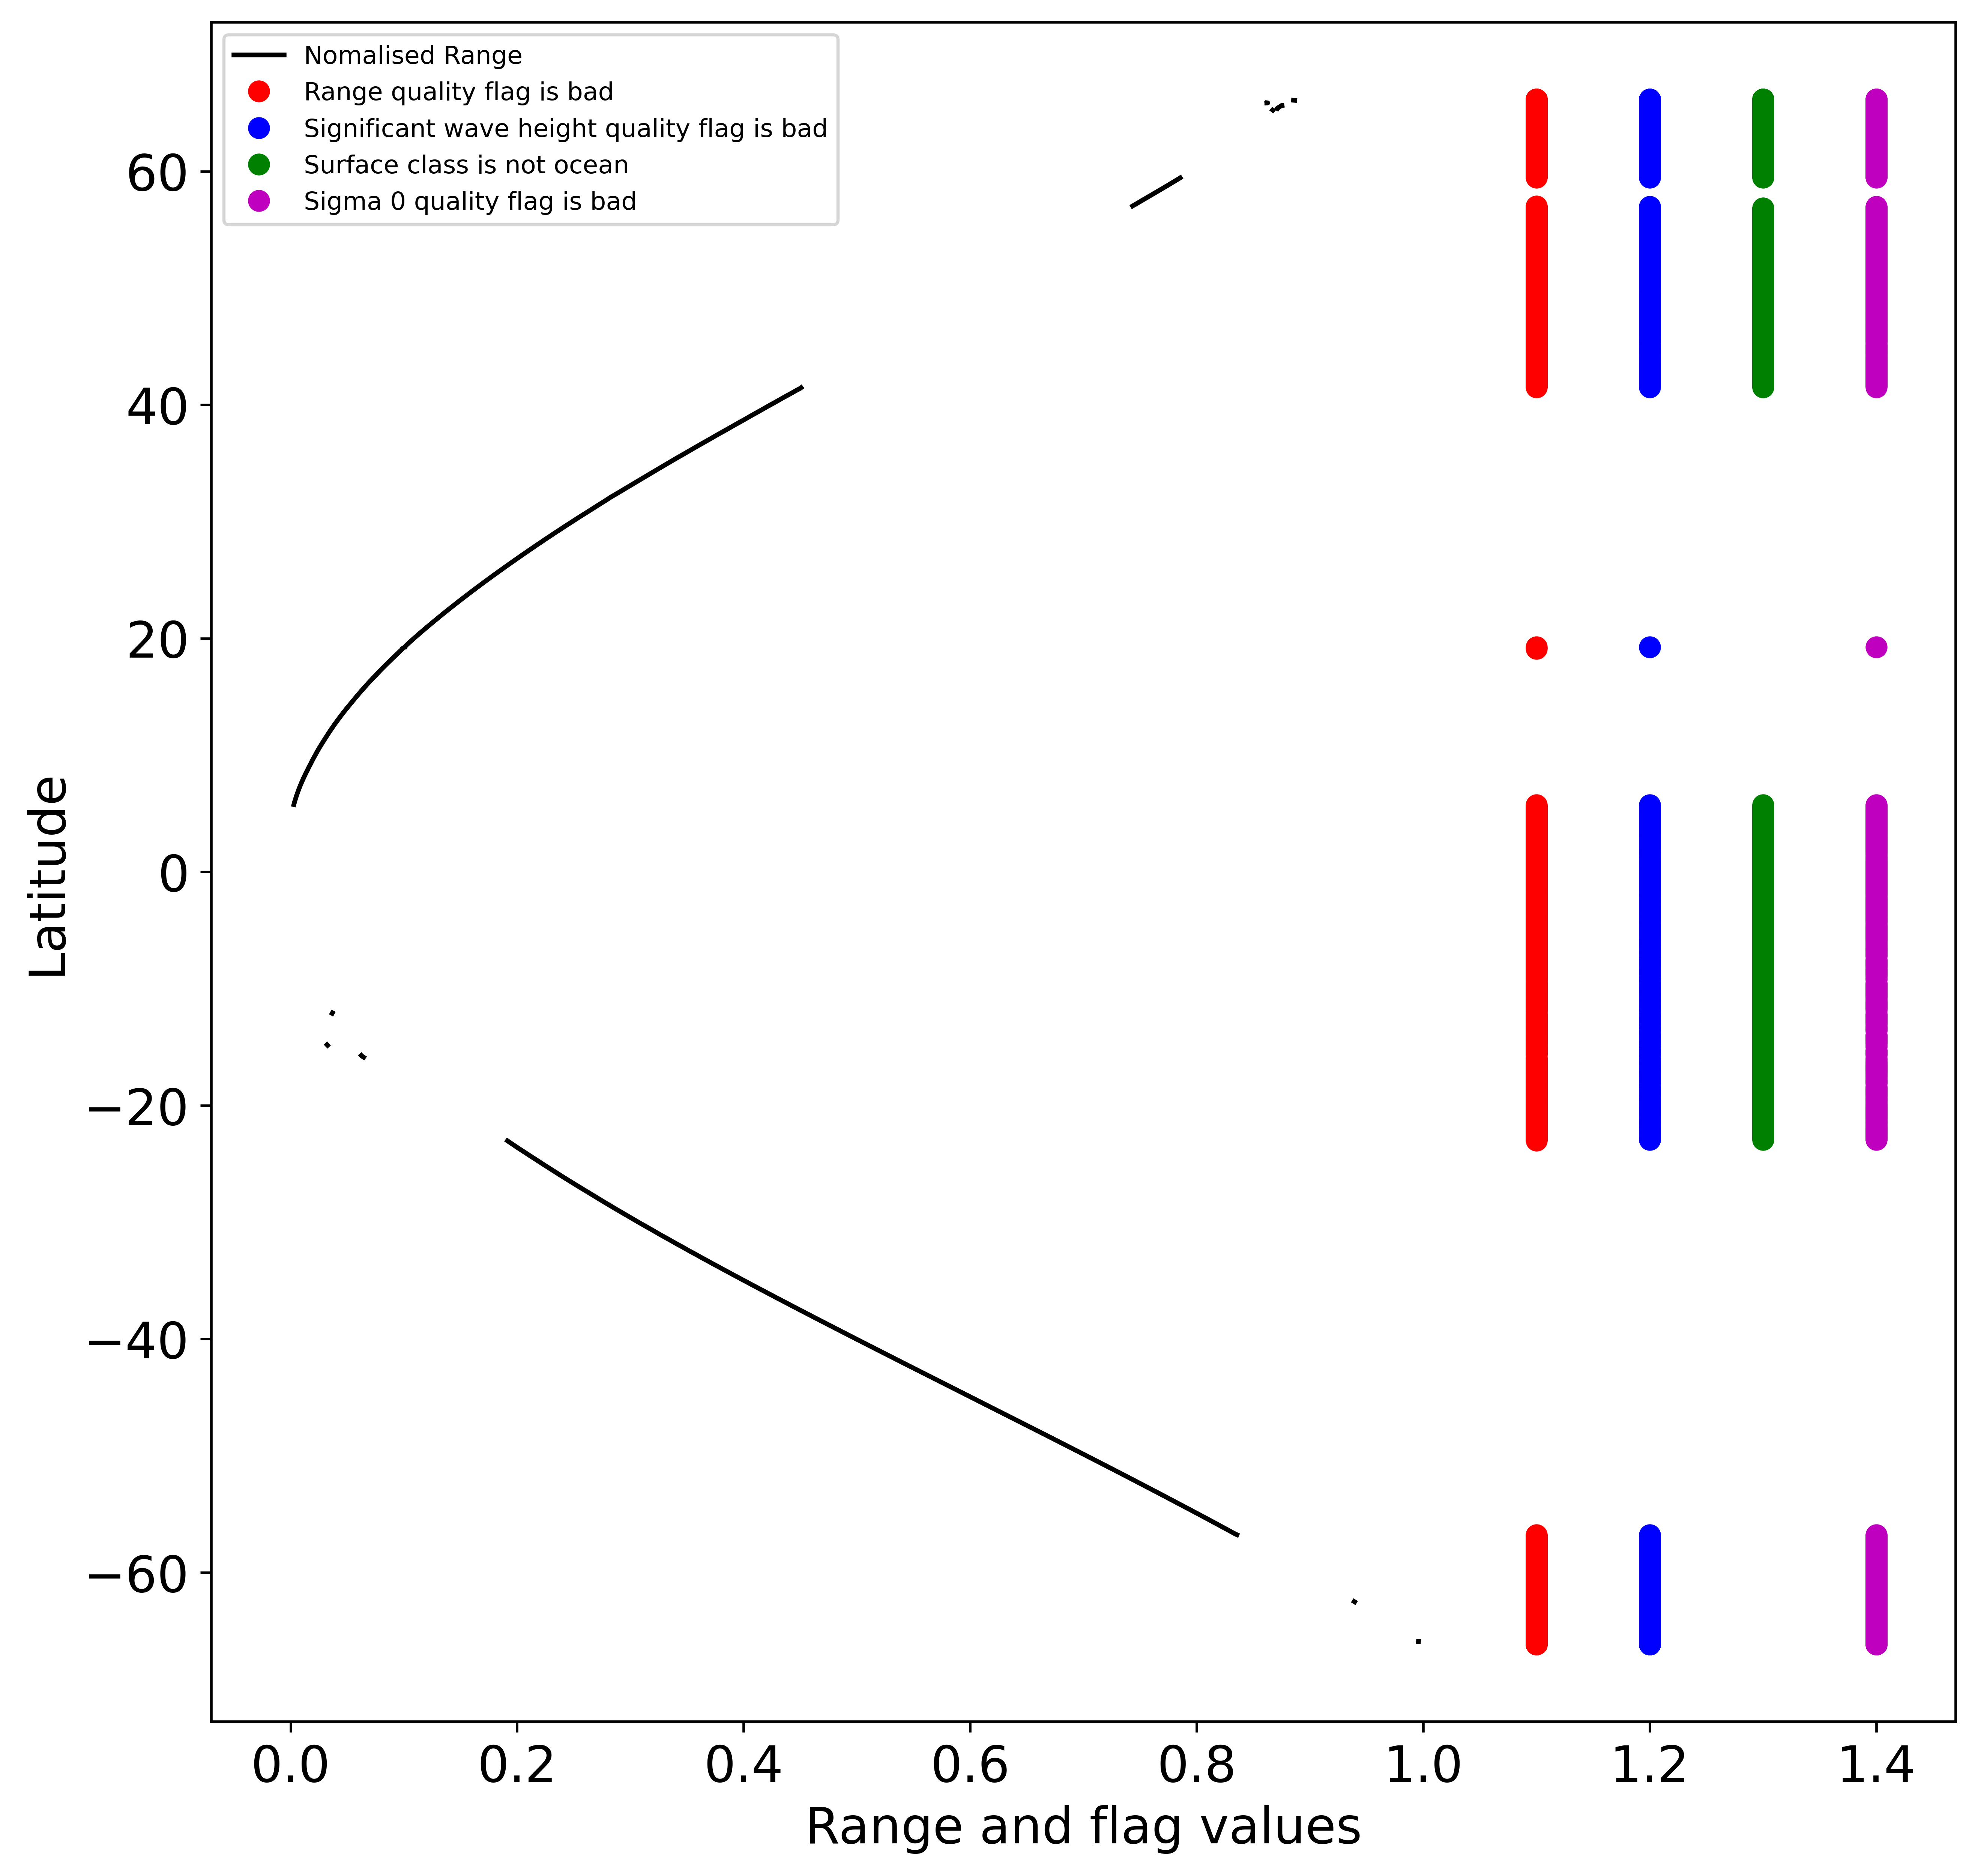

In [7]:
norm_range = range_ku - np.nanmin(range_ku)
norm_range = norm_range / np.nanmax(abs(norm_range))

flags_range1 = range_ocean_qual_01_ku.astype(float)
flags_range1[flags_range1 != 0.0] = 1.1
flags_range1[flags_range1 == 0.0] = np.nan

flags_range2 = swh_ocean_qual_01_ku.astype(float)
flags_range2[flags_range2 != 0.0] = 1.2
flags_range2[flags_range2 == 0.0] = np.nan

flags_range3 = surface_type_01.astype(float)
flags_range3[flags_range3 != 0.0] = 1.3
flags_range3[flags_range3 == 0.0] = np.nan

flags_range4 = sig0_ocean_qual_01_ku.astype(float)
flags_range4[flags_range4 != 0.0] = 1.4
flags_range4[flags_range4 == 0.0] = np.nan

fig1 = plt.figure(figsize=(10, 10), dpi=600)
ax = plt.subplot(1,1,1)
p1, = ax.plot(norm_range, lat, 'k', label='Nomalised Range')
p2, = ax.plot(flags_range1, lat, 'ro',linewidth=0.0, label='Range quality flag is bad')
p3, = ax.plot(flags_range2, lat, 'bo',linewidth=0.0, label='Significant wave height quality flag is bad')
p4, = ax.plot(flags_range3, lat, 'go',linewidth=0.0, label='Surface class is not ocean')
p5, = ax.plot(flags_range4, lat, 'mo',linewidth=0.0, label='Sigma 0 quality flag is bad')
plt.xlabel('Range and flag values', fontsize=16)
plt.ylabel('Latitude', fontsize=16)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, fontsize=8)
plt.savefig('Quality_flags')
plt.show()

Now we will plot some  variables on a map. This will clearly show the data to be a 'line' or 'track' of measurements along the orbit, and also that a file contains data from one half orbit.

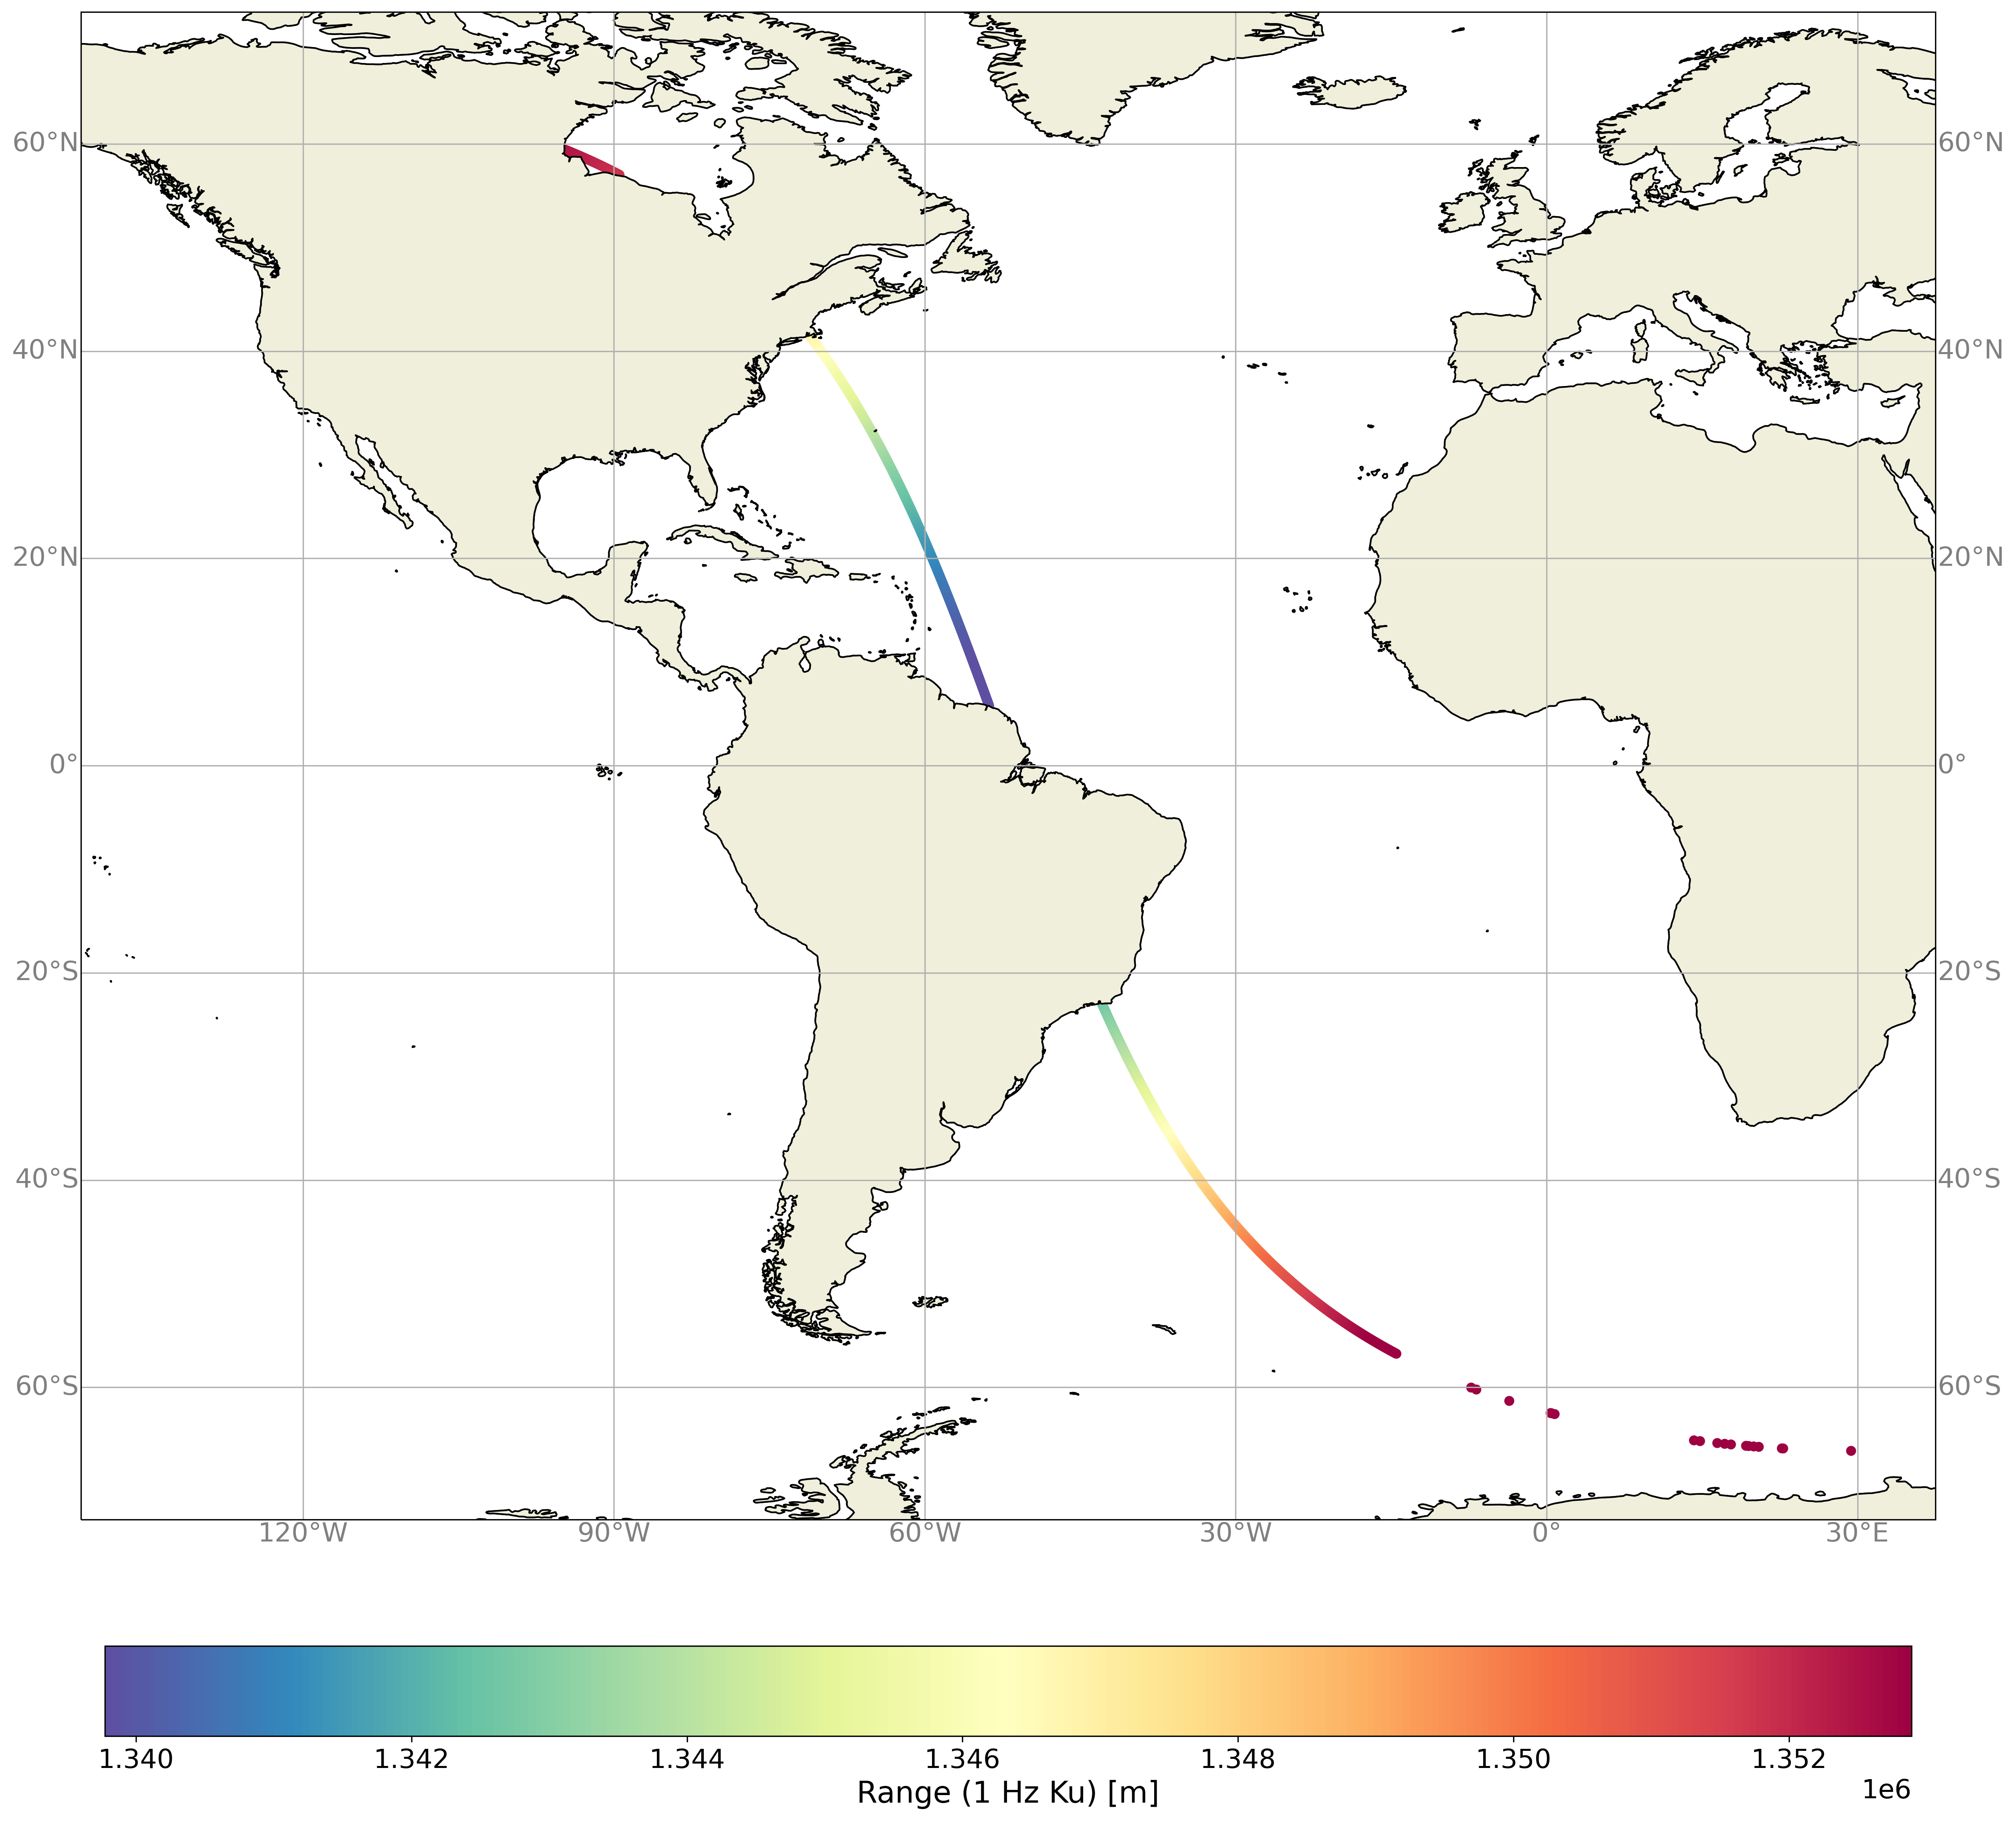

In [8]:
fig1 = plt.figure(figsize=(20, 20), dpi=300)

#define a projection for our map
m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
#vmin and vmax for the scale are truncated slightly to help viewing; 
#the satellite is at a distance around 1336 km from the surface
low_pc = np.percentile(range_ku[np.isfinite(range_ku)],5)
high_pc = np.percentile(range_ku[np.isfinite(range_ku)],95)
range_ku[range_ku < low_pc] = low_pc
range_ku[range_ku > high_pc] = high_pc

f1 = m.scatter(lon, lat, c=range_ku, cmap='Spectral_r', marker='o', edgecolors=None, linewidth=0.0, vmin=low_pc, vmax=high_pc)
m.coastlines(resolution=land_resolution, color='black', linewidth=1)
m.add_feature(land_poly)
g1 = m.gridlines(draw_labels = True)
g1.top_labels = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}

cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Range (1 Hz Ku) [m]', size=18)
plt.savefig('fig_range')
plt.show()

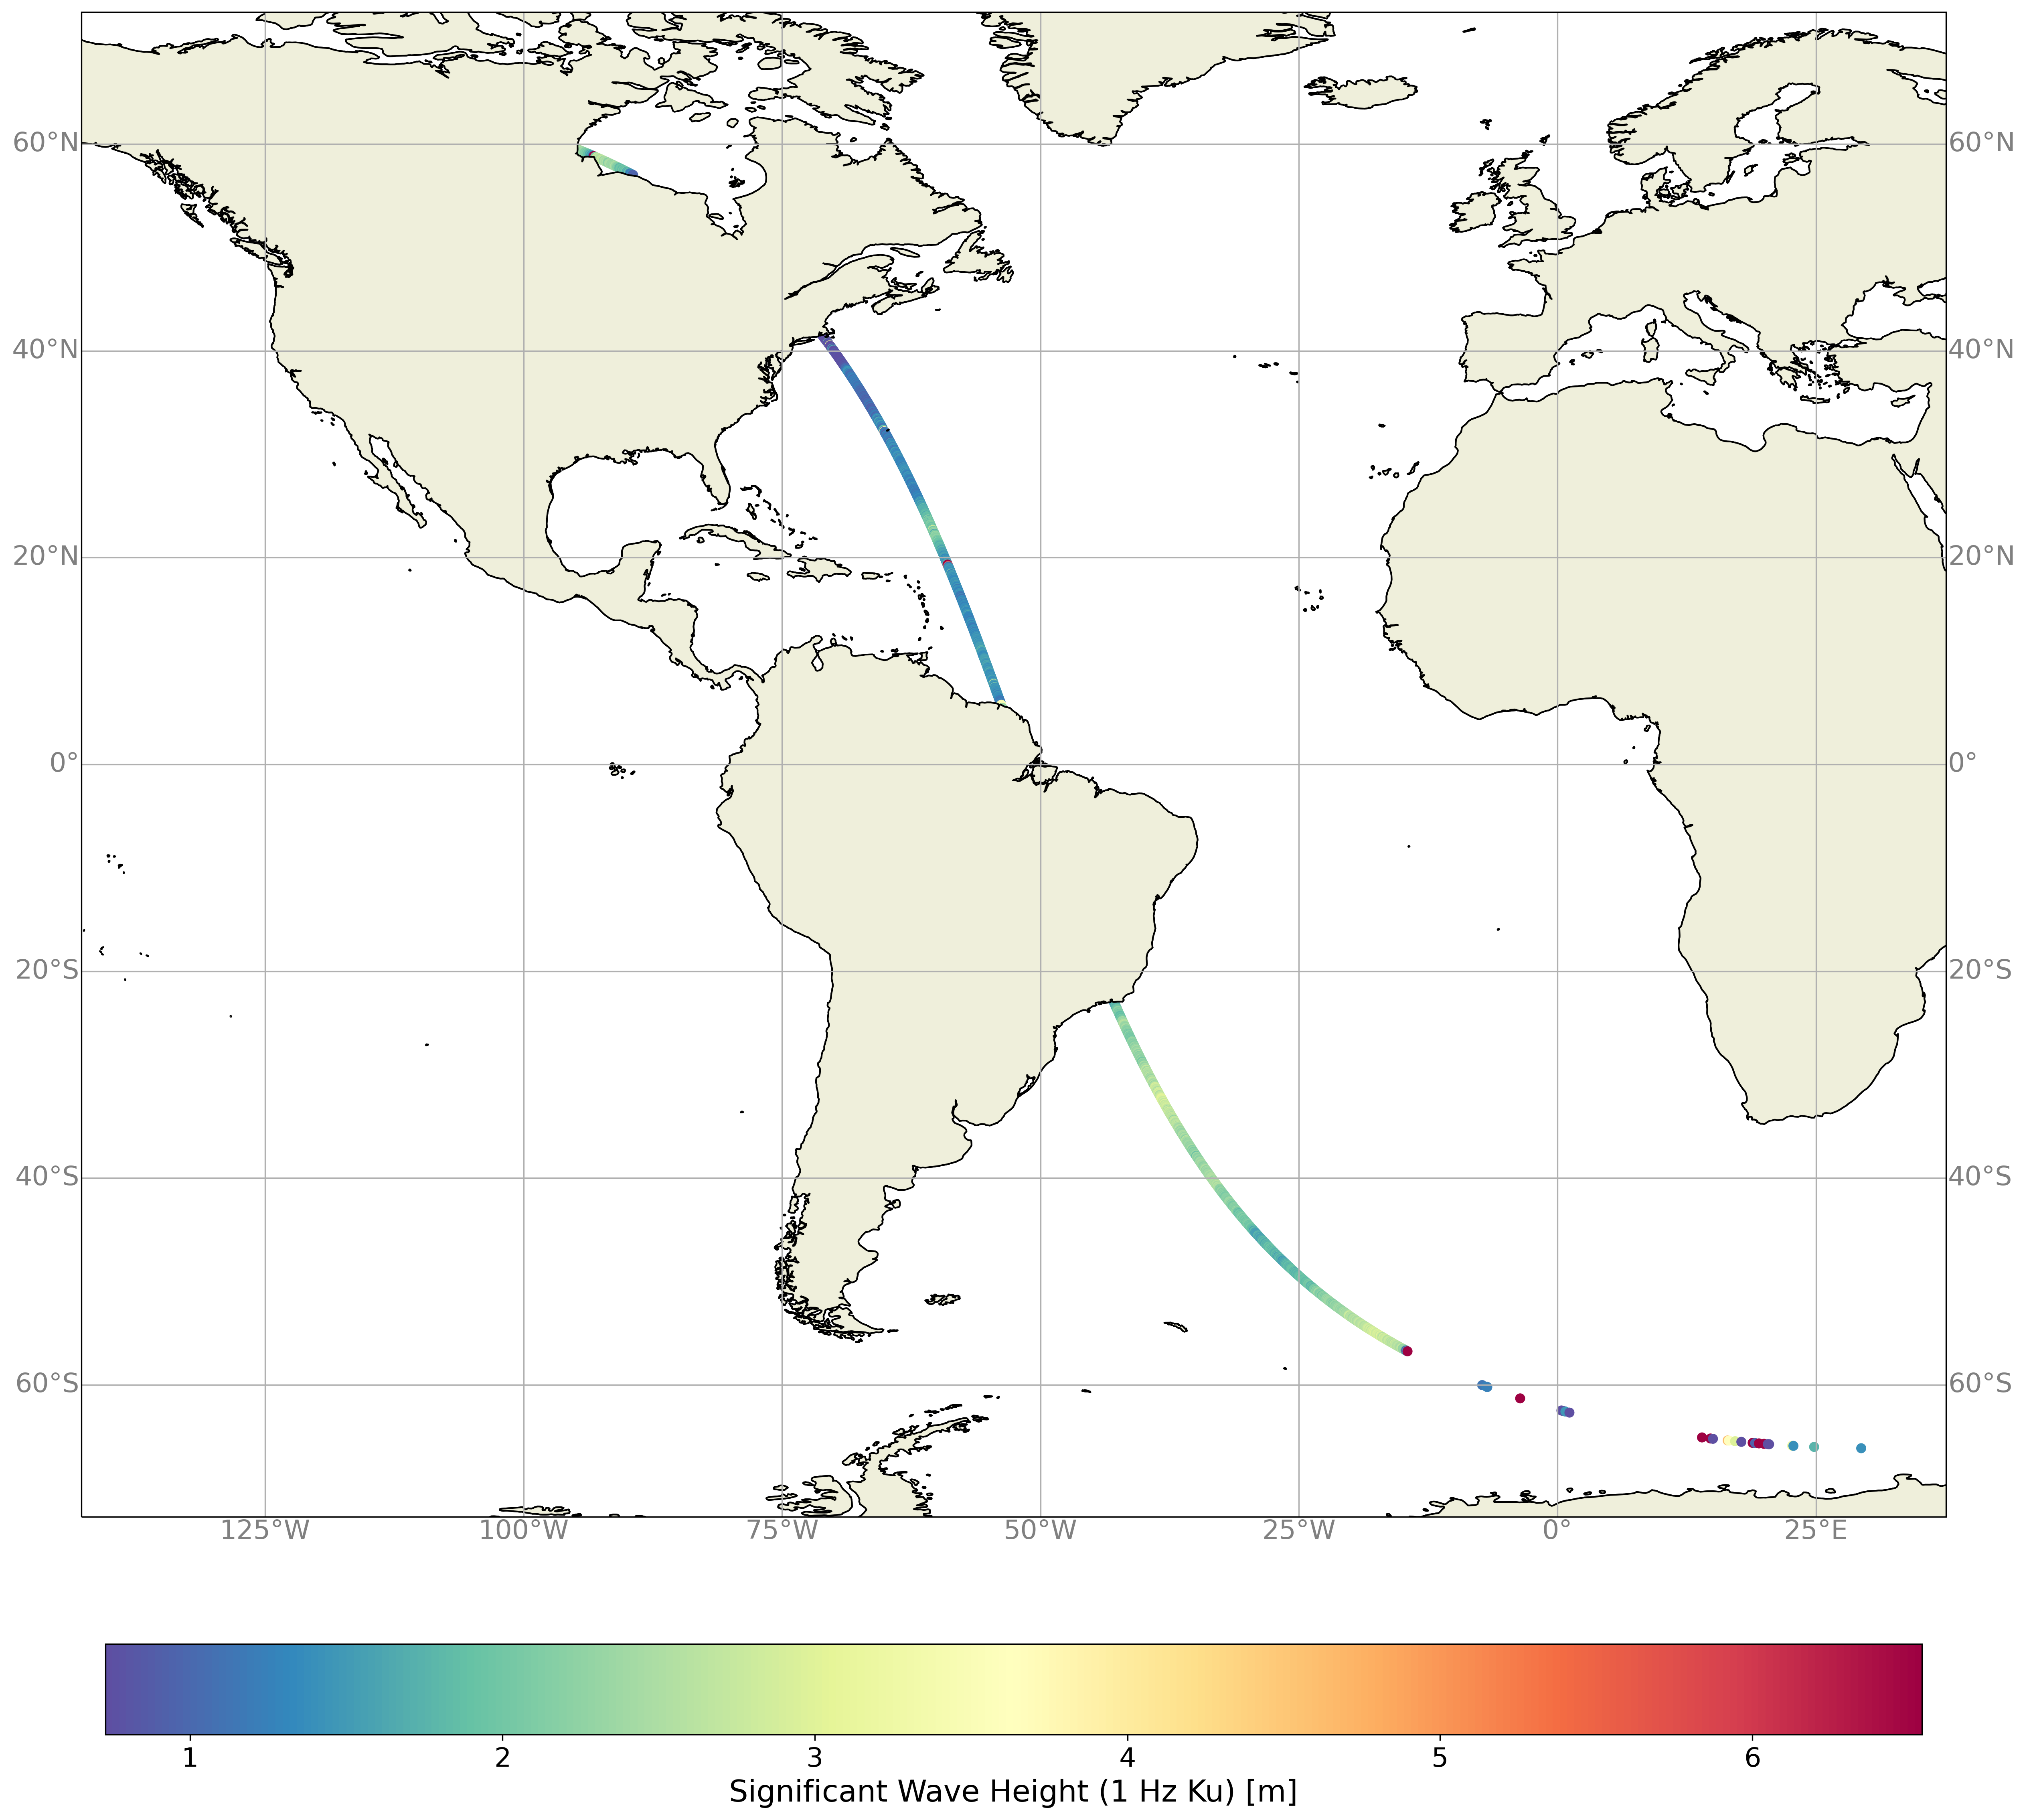

In [9]:
fig1 = plt.figure(figsize=(20, 20), dpi=300)

#define a projection for our map
m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
#vmin and vmax for the scale are truncated slightly to help viewing; 
#upper limit depends if you have strong waves in your data (storm, or swell). Lower limit is 0
low_pc = np.percentile(swh_ocean_01_ku[np.isfinite(swh_ocean_01_ku)],5)
high_pc = np.percentile(swh_ocean_01_ku[np.isfinite(swh_ocean_01_ku)],95)
swh_ocean_01_ku[swh_ocean_01_ku < low_pc] = low_pc
swh_ocean_01_ku[swh_ocean_01_ku > high_pc] = high_pc

f1 = m.scatter(lon, lat, c=swh_ocean_01_ku, cmap='Spectral_r', marker='o', edgecolors=None, linewidth=0.0, vmin=low_pc, vmax=high_pc)
m.coastlines(resolution=land_resolution, color='black', linewidth=1)
m.add_feature(land_poly)
g1 = m.gridlines(draw_labels = True)
g1.top_labels = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}

cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Significant Wave Height (1 Hz Ku) [m]', size=18)
plt.savefig('fig_SWH')
plt.show()

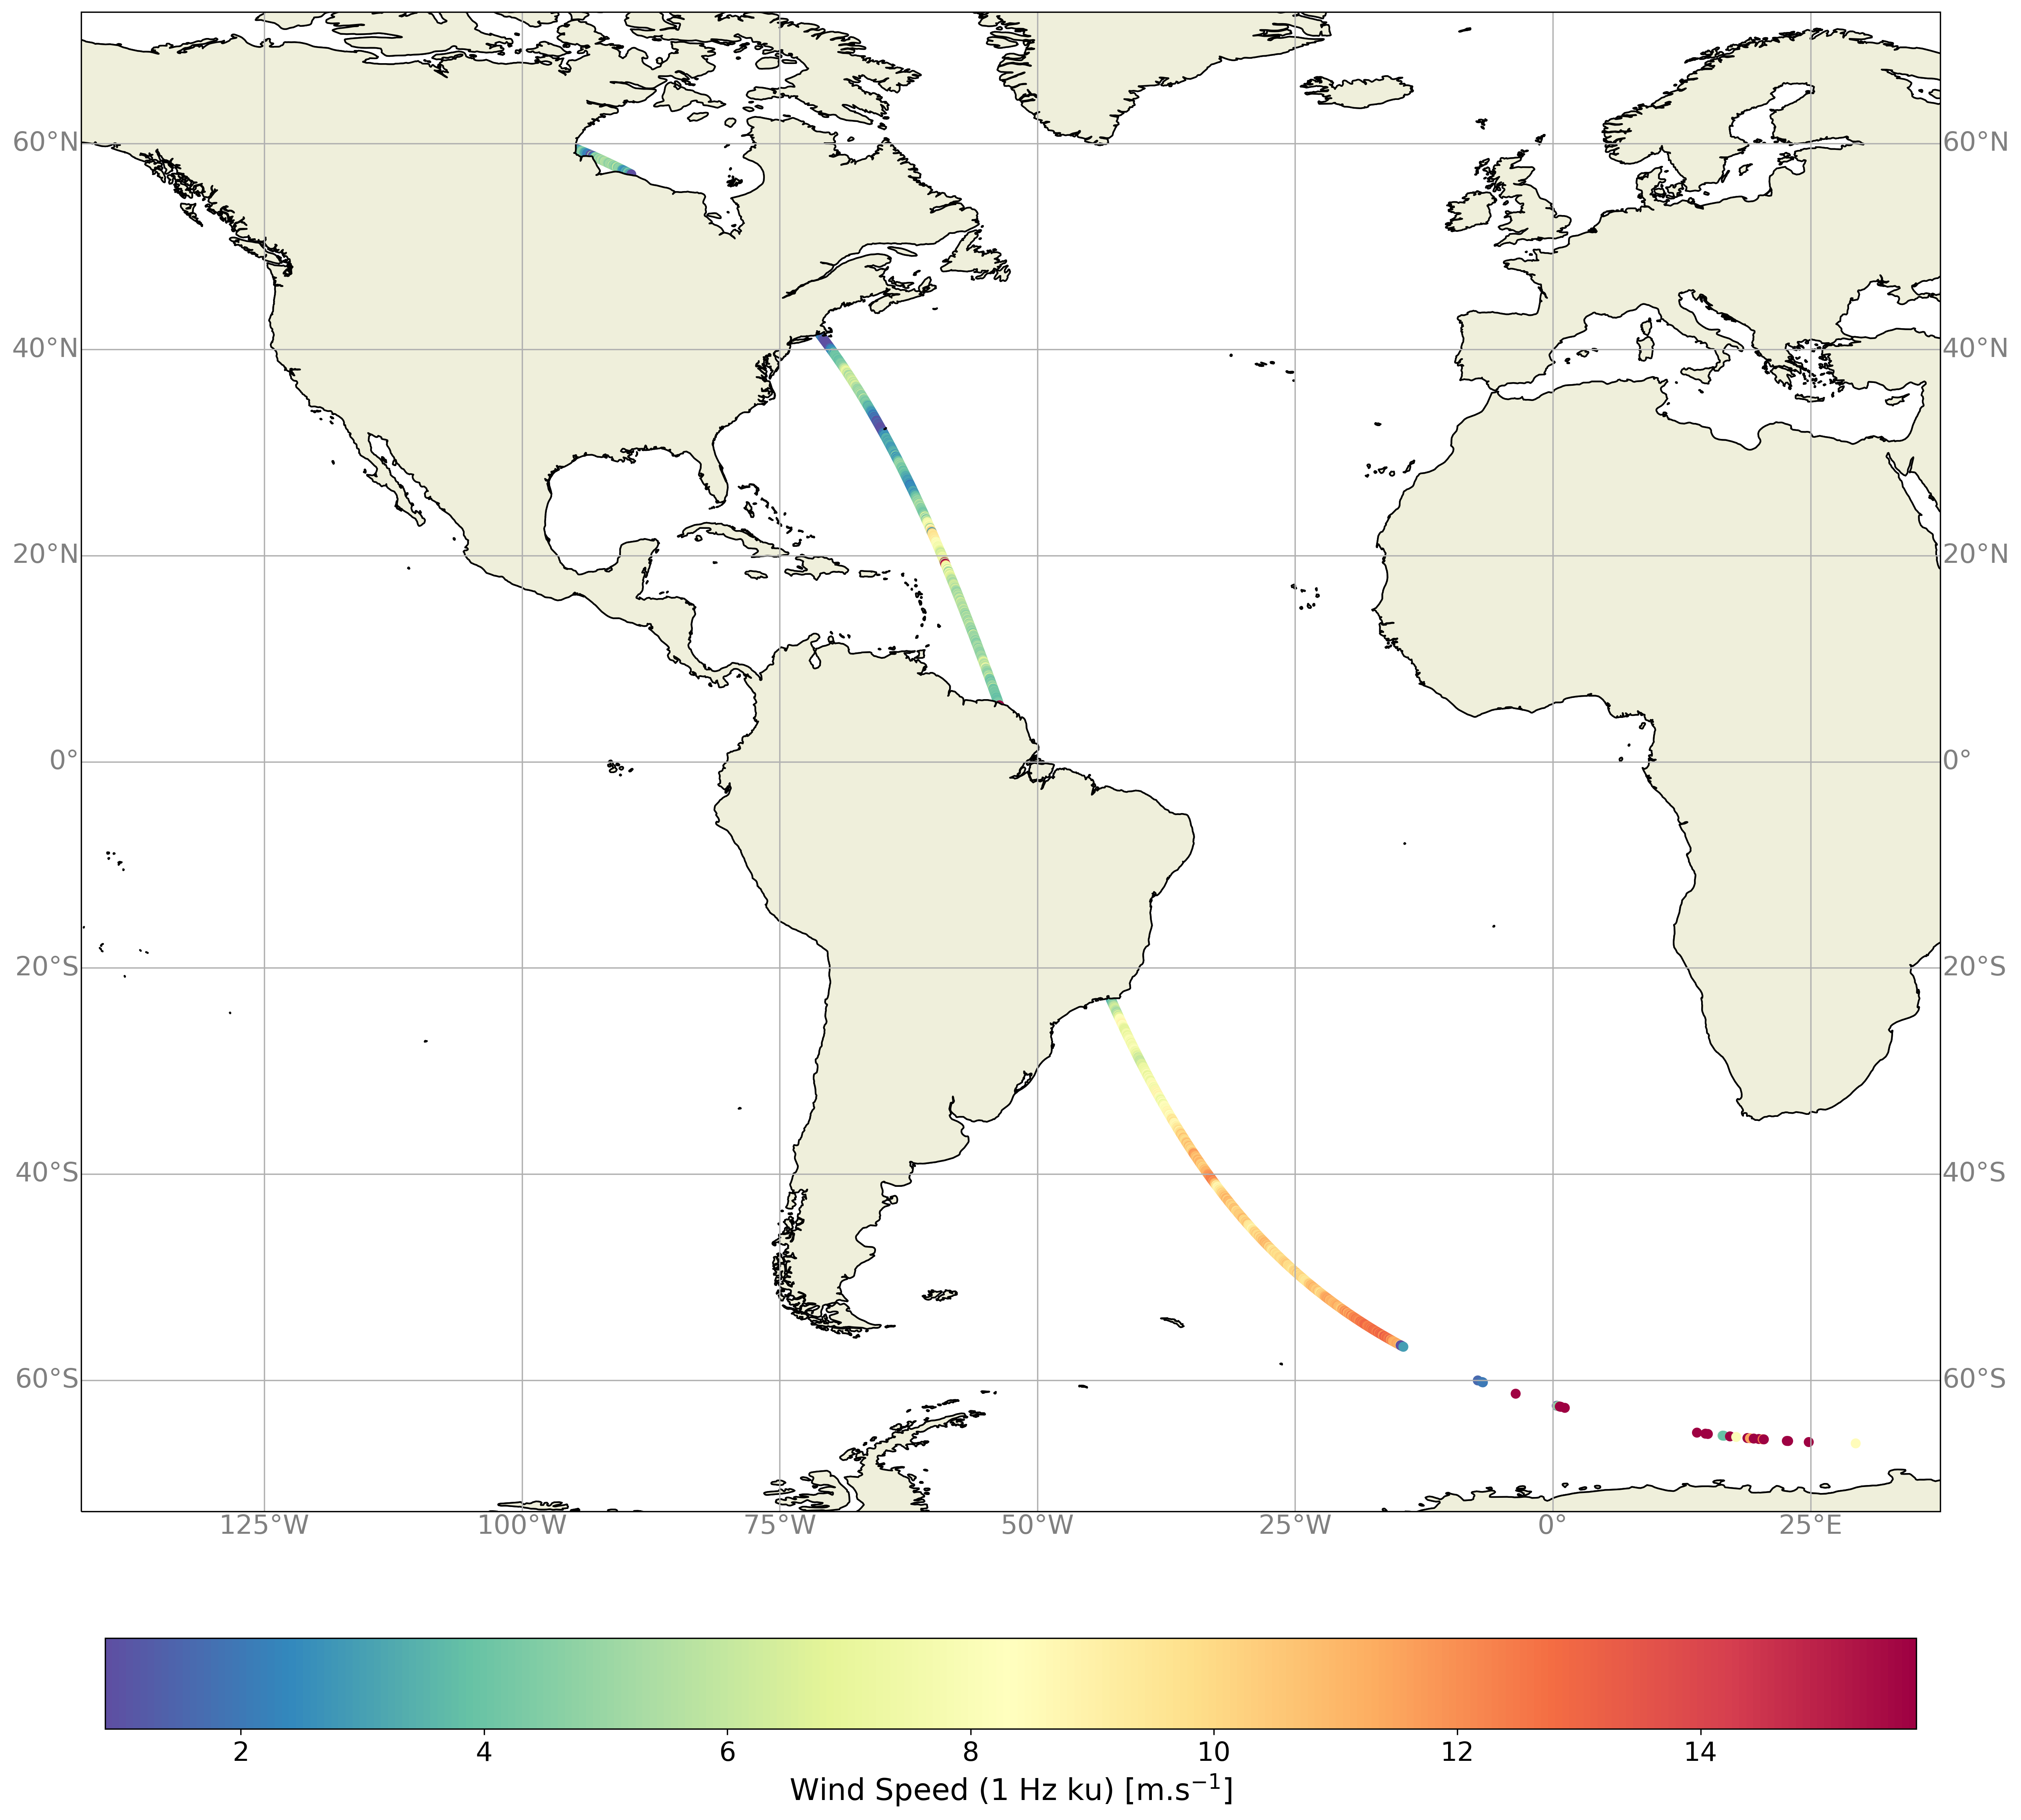

In [10]:
fig1 = plt.figure(figsize=(20, 20), dpi=300)

#define a projection for our map
m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
#vmin and vmax for the scale are truncated slightly to help viewing; 
#upper limit depends if you have a storm or not in your data. 0 is the lower limit. 
low_pc = np.percentile(wind_speed_alt[np.isfinite(wind_speed_alt)],5)
high_pc = np.percentile(wind_speed_alt[np.isfinite(wind_speed_alt)],95)
wind_speed_alt[wind_speed_alt < low_pc] = low_pc
wind_speed_alt[wind_speed_alt > high_pc] = high_pc

f1 = m.scatter(lon, lat, c=wind_speed_alt, cmap='Spectral_r', marker='o', edgecolors=None, linewidth=0.0, vmin=low_pc, vmax=high_pc)
m.coastlines(resolution=land_resolution, color='black', linewidth=1)
m.add_feature(land_poly)
g1 = m.gridlines(draw_labels = True)
g1.top_labels = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}

cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Wind Speed (1 Hz ku) [m.s$^{-1}$]', size=18)
plt.savefig('fig_WS')
plt.show()

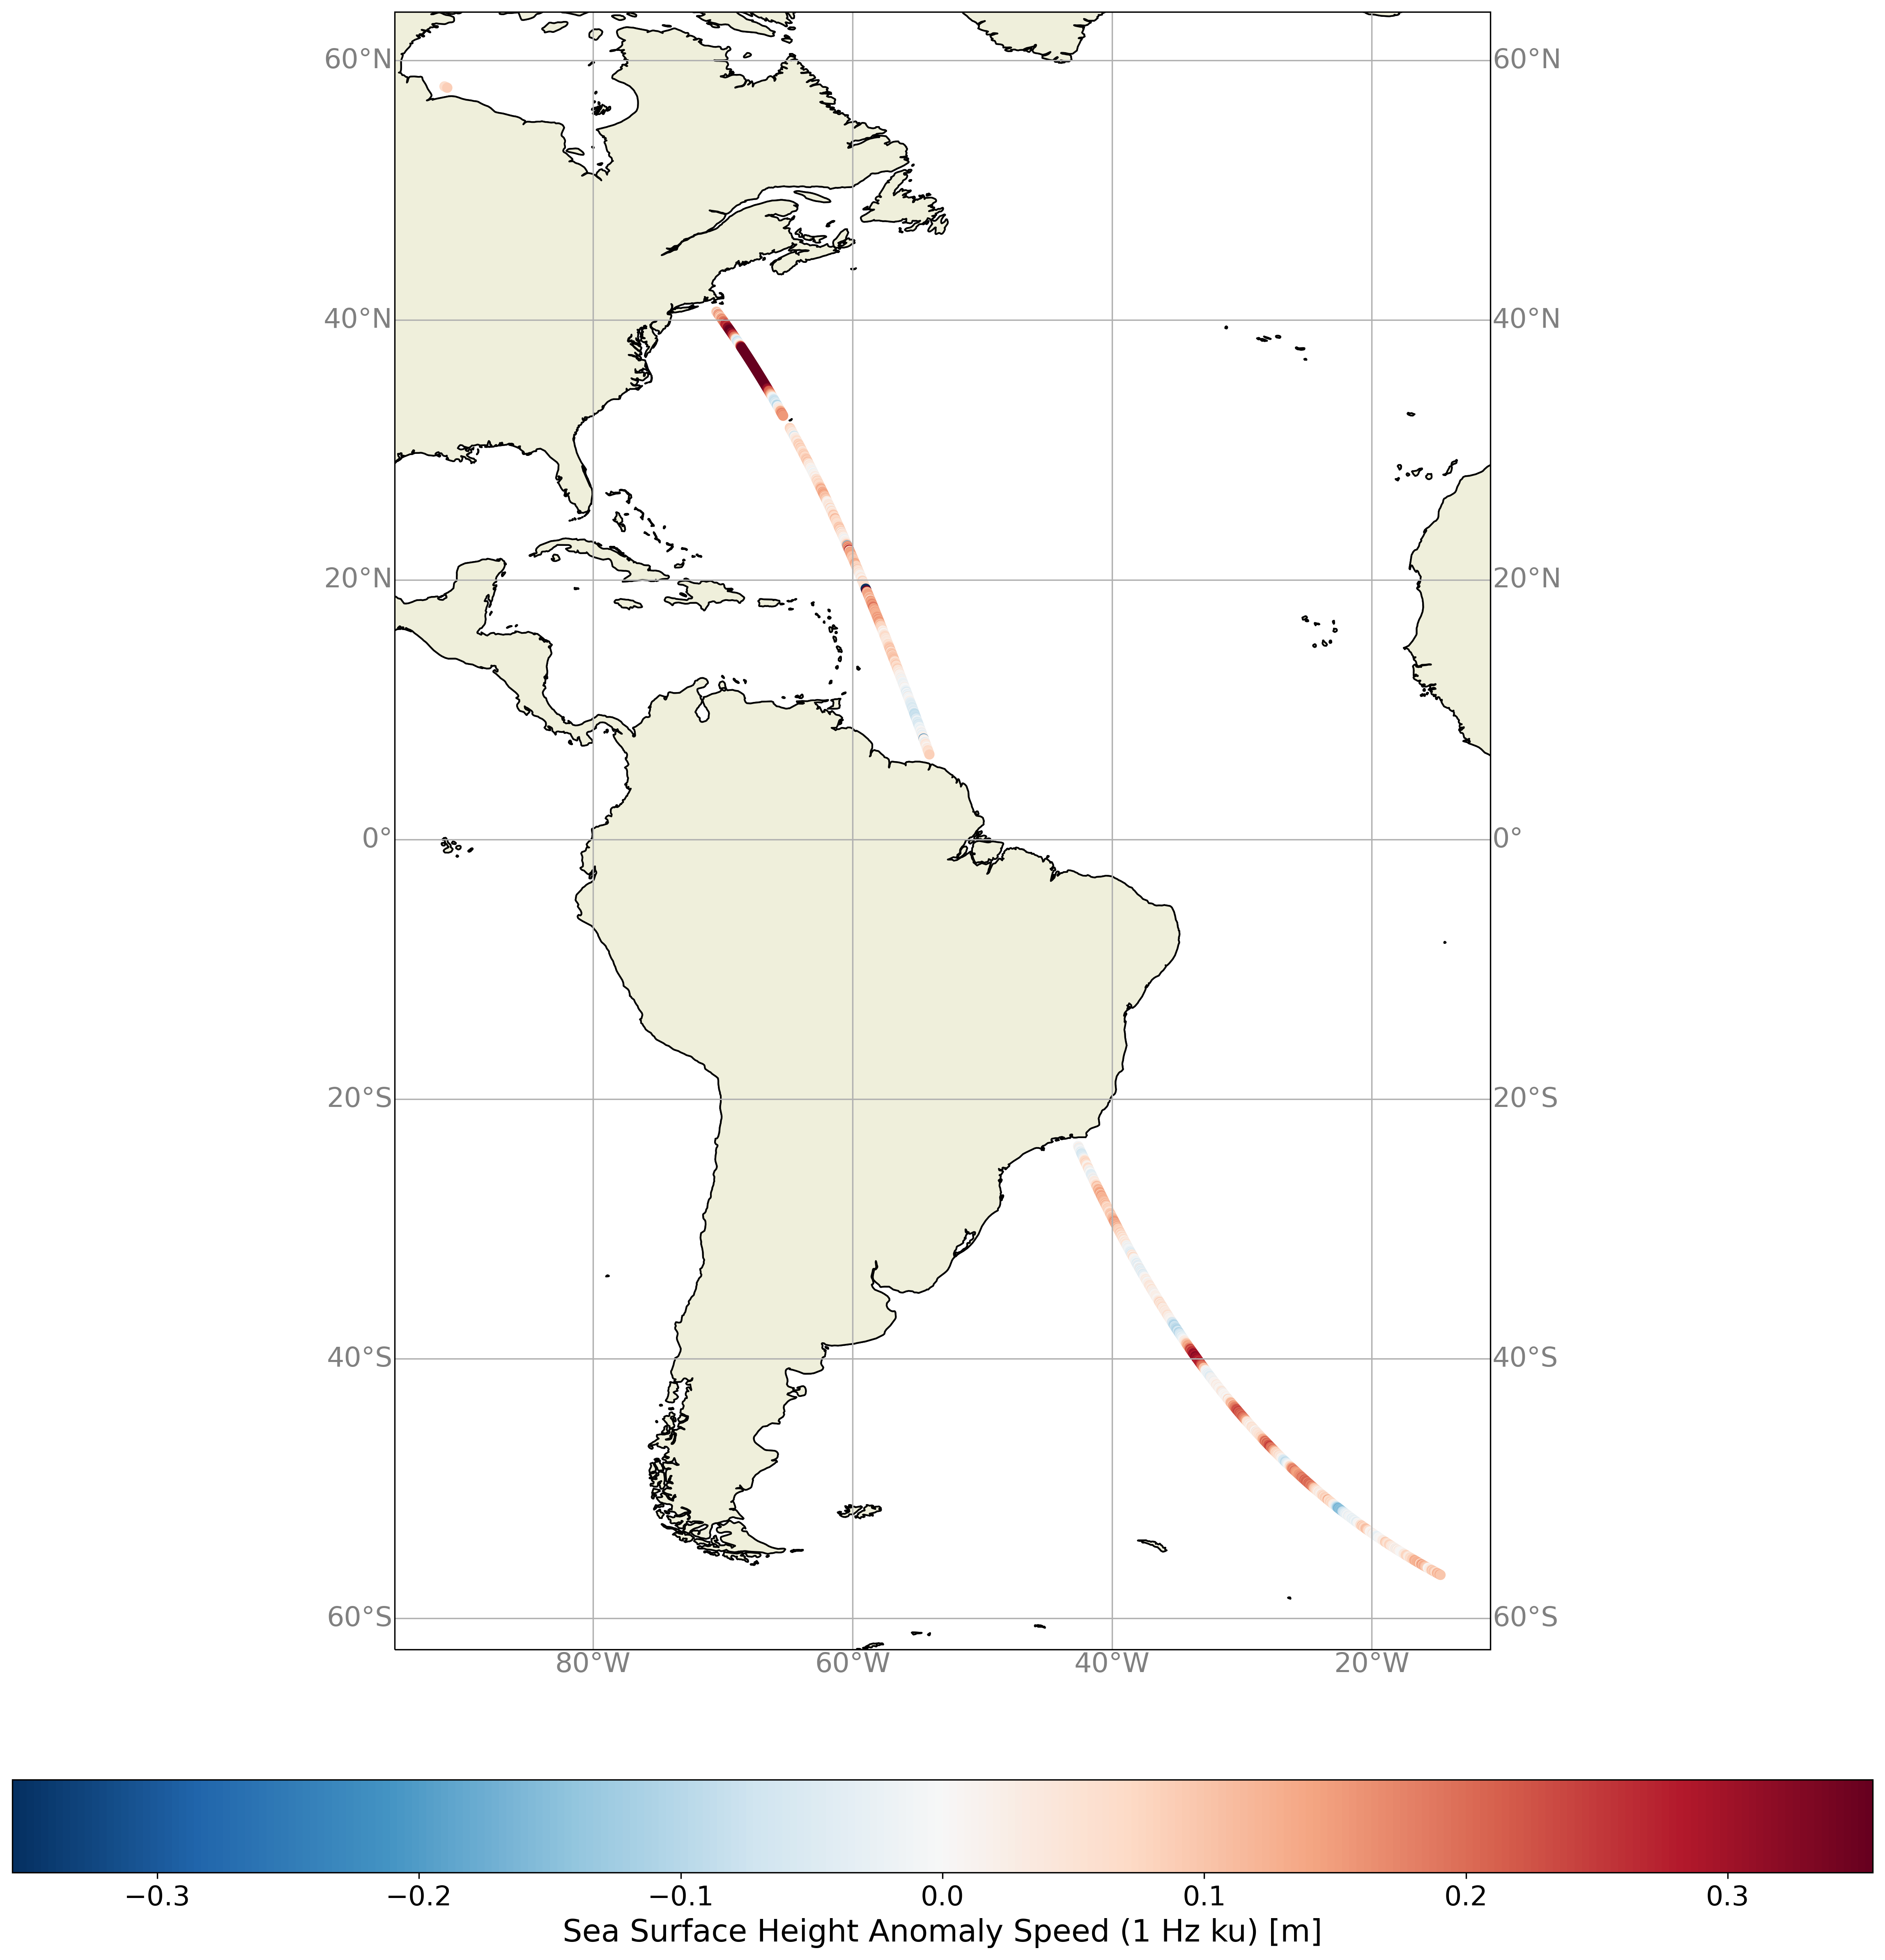

In [11]:
fig1 = plt.figure(figsize=(20, 20), dpi=300)

#define a projection for our map
m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
#vmin and vmax for the scale are truncated slightly to help viewing; 
#within an intense current ssha can be +/- 1 m; quiet areas are more like +/- 0.15-0.2
abs_ssha_01_ku = abs(ssha_01_ku)
high_pc = np.percentile(abs_ssha_01_ku[np.isfinite(ssha_01_ku)],95)
ssha_01_ku[ssha_01_ku < high_pc*-1] = high_pc*-1
ssha_01_ku[ssha_01_ku > high_pc] = high_pc

f1 = m.scatter(lon, lat, c=ssha_01_ku, cmap='RdBu_r', marker='o', edgecolors=None, linewidth=0.0, vmin=-1*high_pc, vmax=high_pc)
m.coastlines(resolution=land_resolution, color='black', linewidth=1)
m.add_feature(land_poly)
g1 = m.gridlines(draw_labels = True)
g1.top_labels = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}

cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Sea Surface Height Anomaly Speed (1 Hz ku) [m]', size=18)
plt.savefig('fig_SSHA')
plt.show()

That's the end of this exercise. Next we will look at the Sea level Anomalies or Sea Surface Height Anomalies and how they can be computed (S6_SLAs)

<br> <a href="./S6_data_access.ipynb">2 - S6 data access >></a><span style="float:right;"><a href="./4_S6_SLAs.ipynb">4 - S6 Sea-level anomalies >></a> 
    
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>